<h1>Hypothesis: "Antartic locations with subterrainian lake will have flatter surafce ice slopes"</h1>



Data Used: 

lakes:
    https://nsidc.org/data/nsidc-0523/versions/1
    https://www.npolar.no/quantarctica/#toggle-id-15 
    wright & siegert

slopes:
    https://www.bas.ac.uk/project/bedmap-2/#data
    https://www.pgc.umn.edu/data/rema/

support:
    https://usicecenter.gov/Products/AntarcData "Weekly Antartic Shapefile"
    https://www.npolar.no/quantarctica/ (this has mostly everything)
    https://www.bas.ac.uk/data/our-data/data-systems/



In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as xrio
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from shapely.geometry import shape
from raster_tools import surface, Raster
import cartopy.crs as ccrs
import numpy as np

<h3>Lake Locations</h3>

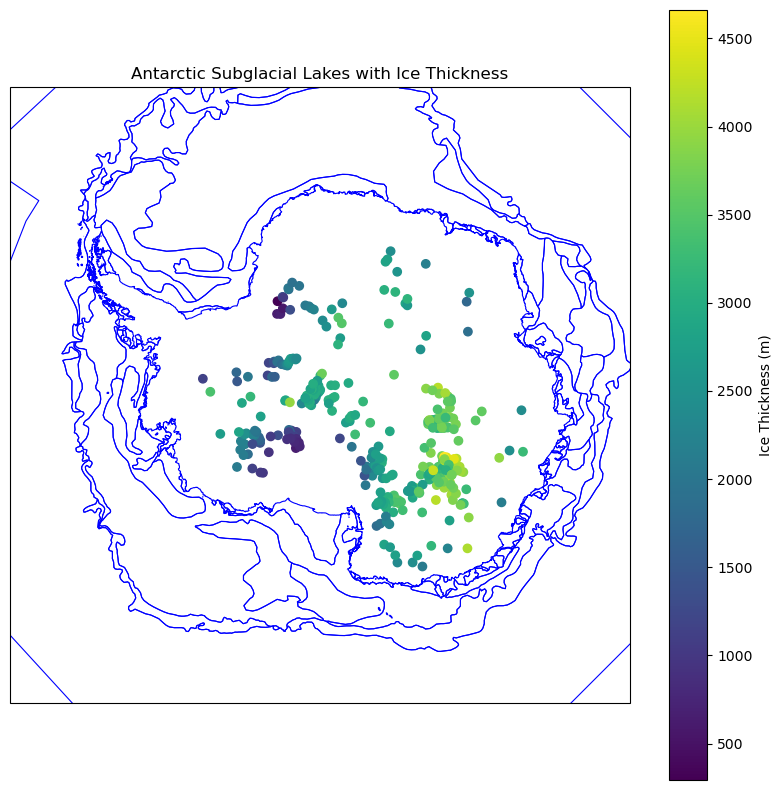

In [7]:
# Load Antarctic subglacial lakes
lakes = pd.read_csv('data/lakes/subglacial_lakes_2012update.csv', encoding='latin1')
lakes.rename(columns={'Lat.         oN': 'Latitude', 'Lon.       oE': 'Longitude'}, inplace=True)
lakes_gdf = gpd.GeoDataFrame(lakes, geometry=gpd.points_from_xy(lakes['Longitude'], lakes['Latitude']))

# Set lakes CRS to WGS84 (EPSG:4326) and transform to Antarctic Polar Stereographic (EPSG:3031)
lakes_gdf.set_crs(epsg=4326, inplace=True)
lakes_gdf = lakes_gdf.to_crs(epsg=3031)

# Load Antarctic shapefile and transform to EPSG:3031
world = gpd.read_file('data/antarc241115/ANTARC241115.shp')
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')
lakes_gdf.plot(ax=ax, cmap='viridis', column='Ice thickness m', legend=True, 
               legend_kwds={'label': "Ice Thickness (m)"}, transform=ccrs.SouthPolarStereo())

# Adjust map extent if needed
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Antarctic Subglacial Lakes with Ice Thickness")
plt.show()

<h3>Ice Thickness</h3>

In [8]:
thickness_tif_path = 'data\\bedmap2_tiff\\bedmap2_thickness.tif'
thickness_xr = xrio.open_rasterio(thickness_tif_path)

thickness_xr

<xarray.DataArray (band: 1, y: 6667, x: 6667)> Size: 89MB
[44448889 values with dtype=int16]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 53kB -3.333e+06 -3.332e+06 ... 3.332e+06 3.333e+06
  * y            (y) float64 53kB 3.333e+06 3.332e+06 ... -3.332e+06 -3.333e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  4621
    STATISTICS_MEAN:     1926.6438367784
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   1052.6332469716
    _FillValue:          32767
    scale_factor:        1.0
    add_offset:          0.0

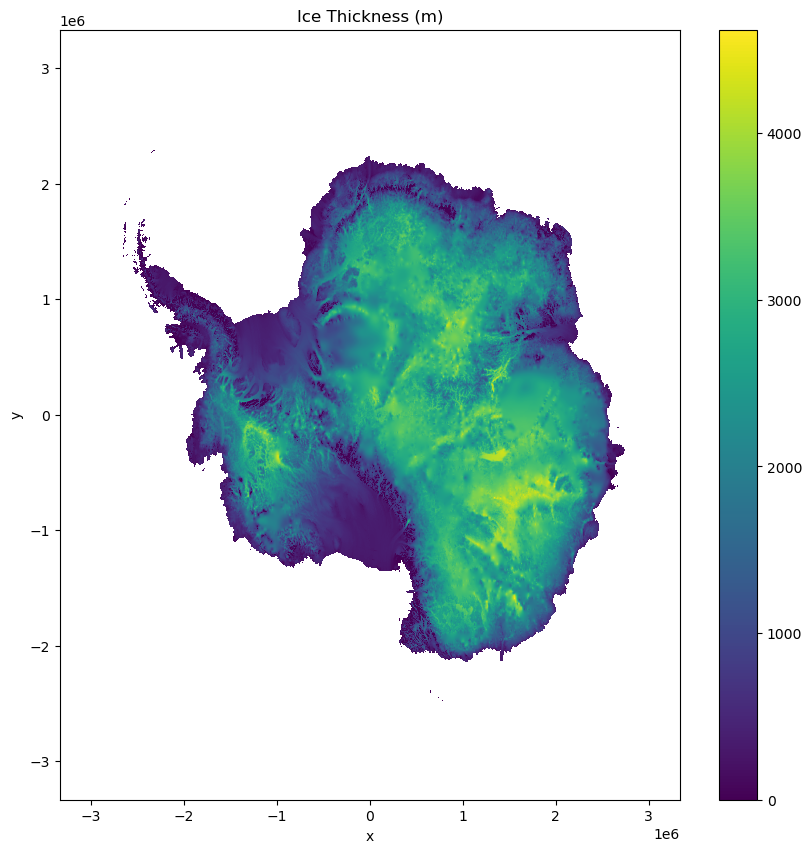

In [9]:
thickness_xr_masked = thickness_xr.where(thickness_xr != 32767)

thickness_xr_masked.plot(figsize=(10, 10), cmap='viridis')
plt.title("Ice Thickness (m)")
# plt.colorbar(label='Pixel Values')
plt.show()

<h5>Update Lake GDF to have thicknesses</h5>

In [11]:
def add_ice_thickness_to_lakes(lakes_gdf, thickness_xr):
    """
    Adds ice thickness values from thickness_xr to lakes_gdf based on lake coordinates.
    Args:
    - lakes_gdf (GeoDataFrame): DataFrame containing lake locations and metadata.
    - thickness_xr (xarray.DataArray): The ice thickness xarray containing ice thickness data.
    
    Returns:
    - lakes_gdf (GeoDataFrame): The lakes GeoDataFrame with an additional 'ice_thickness' column.
    """
    # Create a new column 'ice_thickness' in lakes_gdf
    lakes_gdf['ice_thickness'] = [
        thickness_at_lake(thickness_xr, point)  # Get ice thickness at lake location
        for point in lakes_gdf.geometry
    ]
    
    return lakes_gdf

def thickness_at_lake(thickness_xr, point):
    """
    Extract the ice thickness value at a specific lake location.
    Args:
    - thickness_xr (xarray.DataArray): The ice thickness data
    - point (shapely.geometry.point.Point): The lake point geometry
    
    Returns:
    - thickness_value (float): Ice thickness at the lake location
    """
    # Extract coordinates of the lake point
    x, y = point.x, point.y
    
    # Extract ice thickness at the lake location (nearest neighbor interpolation)
    thickness_value = thickness_xr.sel(x=x, y=y, method='nearest')
    
    return thickness_value.item()  # Convert to scalar value

# Call the function to add ice thickness to lakes_gdf
lakes_gdf = add_ice_thickness_to_lakes(lakes_gdf, thickness_xr)

# Check the results
print(lakes_gdf[['Name', 'ice_thickness']].head())

              Name  ice_thickness
0  Sovetskaya Lake           3919
1      Lake Vostok           3303
2           SPRI-3           3474
3           SPRI-4           2344
4           SPRI-5           3729


In [12]:
lakes_gdf = lakes_gdf.drop(columns=["Ice thickness m"])
lakes_gdf

,Tally,Name,Latitude,Longitude,Length m,Width m,Depth m,Area km2,Volume km3,References,geometry,ice_thickness
0,1,Sovetskaya Lake,-78.100,88.500,75000,35000.0,NaN,1600.0,NaN,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),3919
1,2,Lake Vostok,-78.150,104.500,280000,44000.0,1067.0,14000.0,5400.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),3303
2,3,SPRI-3,-76.570,124.800,5000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1203517.434 -836466.407),3474
3,4,SPRI-4,-73.280,157.280,3500,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (706469.226 -1687214.515),2344
4,5,SPRI-5,-77.200,119.270,10000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1218054.666 -682702.029),3729
...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1470914.122 -423028.361),3474
375,376,R15Ea_4,-74.084,100.818,1800,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1709145.571 -326593.471),3513
376,377,Site A,-67.800,112.540,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1818
377,378,Site B,-67.870,113.530,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1549


<h3>Calculate Slope From DEM</h3>

In [2]:
dem_path = 'data\\rema_mosaic_500m_v2.0_filled_cop30\\rema_mosaic_500m_v2.0_filled_cop30_dem.tif'

dem_xr = xrio.open_rasterio(dem_path)
dem_xr

<xarray.DataArray (band: 1, y: 11686, x: 10902)> Size: 510MB
[127400772 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 87kB -2.7e+06 -2.7e+06 ... 2.75e+06 2.75e+06
  * y            (y) float64 93kB 3.342e+06 3.342e+06 ... -2.5e+06 -2.5e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [3]:
slp = surface.slope(
    dem_path, degrees=True
)

slp

<raster_tools.Raster (crs='EPSG:3031', masked=True)>
<xarray.DataArray 'raster' (band: 1, y: 11686, x: 10902)> Size: 1GB
dask.array<where, shape=(1, 11686, 10902), dtype=float64, chunksize=(1, 5792, 5792), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 87kB -2.7e+06 -2.7e+06 ... 2.75e+06 2.75e+06
  * y            (y) float64 93kB 3.342e+06 3.342e+06 ... -2.5e+06 -2.5e+06
    spatial_ref  int32 4B 0
Attributes:
    _FillValue:  -999999.0

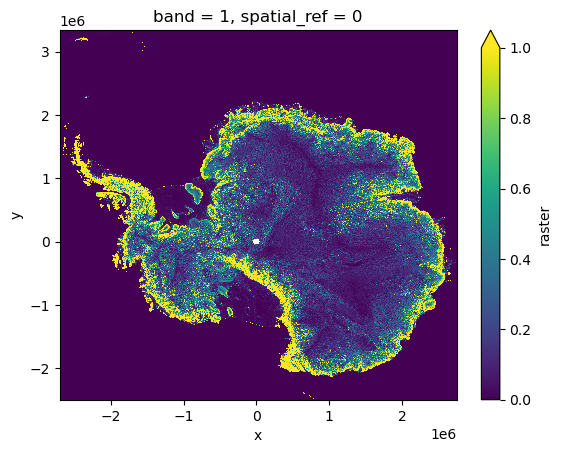

In [4]:
# slp.plot(vmin=0, vmax=5) #decent but could be better
slp.plot(vmin=0, vmax=1)

plt.show()

<h3>Analysis</h3>

<h4>Slope Values at Lake Locations</h4>

In [14]:
lake_coords = np.array([lakes_gdf.geometry.x, lakes_gdf.geometry.y]).T

lake_coords

array([[ 1.29699956e+06,  3.39631288e+04],
       [ 1.25080332e+06, -3.23479733e+05],
       [ 1.20351743e+06, -8.36466407e+05],
       [ 7.06469226e+05, -1.68721451e+06],
       [ 1.21805467e+06, -6.82702029e+05],
       [ 1.42630214e+06, -9.99449671e+05],
       [-9.23610778e+04, -1.59974079e+05],
       [ 1.60686305e+06, -1.08139627e+06],
       [ 1.10819174e+06, -9.20038510e+05],
       [ 1.21930809e+06, -9.32568681e+05],
       [ 1.24452105e+06, -9.22915550e+05],
       [ 1.27415713e+06, -9.12206913e+05],
       [ 1.30162654e+06, -8.34346730e+05],
       [ 1.29678286e+06, -9.76486461e+05],
       [ 1.57498266e+06, -8.92534397e+05],
       [ 1.05600034e+06, -1.06857087e+06],
       [ 5.76847605e+05, -9.32902935e+05],
       [ 1.28310945e+06, -1.03533881e+06],
       [ 1.25550141e+06, -8.77479738e+05],
       [ 1.25663594e+06, -9.11994544e+05],
       [ 1.25644935e+06, -9.29045063e+05],
       [ 1.34966080e+06, -9.34584298e+05],
       [ 1.35553340e+06, -7.94968736e+05],
       [ 1.

In [20]:
print(dir(slp))

['_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_ufunc__', '__class__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__itruediv__', '__ixor__', '__le__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__xor__', '_build_reduce_

In [21]:
# Extract raster data and affine transform
slope_array = slp.to_numpy()  # Convert raster to a NumPy array
affine_transform = slp.affine  # Affine transform for mapping coordinates
nodata_value = slp.null_value  # No-data value

In [ ]:
# Function to map geographic coordinates to array indices
def coords_to_indices(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

# Extract slope values for each lake point
lake_slopes = []
for geom in lakes_gdf.geometry:
    row, col = coords_to_indices(geom.x, geom.y, affine_transform)
    if 0 <= row < slope_array.shape[1] and 0 <= col < slope_array.shape[2]:  # Check bounds
        value = slope_array[0, row, col]  # Access the value from the raster
        lake_slopes.append(value if value != nodata_value else None)
    else:
        lake_slopes.append(None)  # Out-of-bounds points

# Add extracted values to GeoDataFrame
lakes_gdf["slope"] = lake_slopes


In [24]:
lakes_gdf

,Tally,Name,Latitude,Longitude,Length m,Width m,Depth m,Area km2,Volume km3,References,geometry,ice_thickness,slope
0,1,Sovetskaya Lake,-78.100,88.500,75000,35000.0,NaN,1600.0,NaN,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),3919,0.086016
1,2,Lake Vostok,-78.150,104.500,280000,44000.0,1067.0,14000.0,5400.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),3303,0.114682
2,3,SPRI-3,-76.570,124.800,5000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1203517.434 -836466.407),3474,0.029392
3,4,SPRI-4,-73.280,157.280,3500,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (706469.226 -1687214.515),2344,0.227904
4,5,SPRI-5,-77.200,119.270,10000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1218054.666 -682702.029),3729,0.057291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1470914.122 -423028.361),3474,0.095858
375,376,R15Ea_4,-74.084,100.818,1800,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1709145.571 -326593.471),3513,0.056701
376,377,Site A,-67.800,112.540,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1818,0.229883
377,378,Site B,-67.870,113.530,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1549,0.525441
